In [6]:
import numpy as np
import xarray as xr
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [7]:
#nc_files = sorted( glob.glob( r"C:\Users\locfa_v05v5qi\Documents\escadas_termohalinas\raw\Dataset\**\*.nc", recursive=True ) )
nc_files = sorted(glob.glob("C:/Users/aneli/Documents/LOC/PC_casa/Dataset/**/*.nc", recursive=True))

In [8]:
#RECORTE REGIONAL

def subset_region(ds):

    # Ajustar longitudes se estiverem em 0–360
    if float(ds.lon.max()) > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    mask = (
        (ds.lat <= 10) & (ds.lat >= -60) &
        (ds.lon >= -60) & (ds.lon <= -10)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds

# 2) DETECÇÃO DE STAIRCASE 

def detect_staircases(ds):

    profile_dim = ds.lat.dims[0]
    n_profiles = ds.sizes[profile_dim]

    staircase_sf = np.zeros(n_profiles, dtype=bool)
    staircase_dc = np.zeros(n_profiles, dtype=bool)

    for i in range(n_profiles):

        ml_mask_sf = ds.mask_ml_sf_layer.isel({profile_dim: i}) > 0
        ml_mask_dc = ds.mask_ml_dc_layer.isel({profile_dim: i}) > 0

        if np.any(ml_mask_sf):
            staircase_sf[i] = True

        if np.any(ml_mask_dc):
            staircase_dc[i] = True

    ds["staircase_sf"] = (profile_dim, staircase_sf)
    ds["staircase_dc"] = (profile_dim, staircase_dc)

    return ds


In [9]:
dominant_sf_profiles = 0
dominant_dc_profiles = 0
dominant_mixed_profiles = 0

dominant_sf_points = []
dominant_dc_points = []
dominant_mixed_points = []

#LOOP PRINCIPAL

for file in nc_files:

    ds = xr.open_dataset(file)

    # Recorte
    ds = subset_region(ds)

    if ds.sizes.get("Nobs", 0) == 0:
        continue

    # Detectar staircases
    ds = detect_staircases(ds)

    n_region = ds.sizes["Nobs"]

    for i in range(n_region):

        ml_h = ds.ml_h.isel(Nobs=i).values

        sf_layer_mask = ds.mask_ml_sf_layer.isel(Nobs=i).values > 0
        dc_layer_mask = ds.mask_ml_dc_layer.isel(Nobs=i).values > 0

        H_sf = np.nansum(ml_h[sf_layer_mask])
        H_dc = np.nansum(ml_h[dc_layer_mask])

        # Ignora perfis sem staircase
        if (H_sf + H_dc) == 0:
            continue

        lat_val = float(np.round(ds.lat.values[i], 2))
        lon_val = float(np.round(ds.lon.values[i], 2))
        point = (lat_val, lon_val)

        # Classificação de dominância por espessura
        if H_sf > H_dc:
            dominant_sf_profiles += 1
            dominant_sf_points.append(point)

        elif H_dc > H_sf:
            dominant_dc_profiles += 1
            dominant_dc_points.append(point)

        else:
            dominant_mixed_profiles += 1
            dominant_mixed_points.append(point)


# RESULTADOS PERFIS

total_dominant_profiles = (
    dominant_sf_profiles +
    dominant_dc_profiles +
    dominant_mixed_profiles
)

print("\n================ RESULTADOS POR PERFIL ================")

if total_dominant_profiles > 0:

    print("SF dominante:",
          dominant_sf_profiles,
          round(100 * dominant_sf_profiles / total_dominant_profiles, 2), "%")

    print("DC dominante:",
          dominant_dc_profiles,
          round(100 * dominant_dc_profiles / total_dominant_profiles, 2), "%")

    print("Equilibrado:",
          dominant_mixed_profiles,
          round(100 * dominant_mixed_profiles / total_dominant_profiles, 2), "%")

# RESULTADOS ESPACIAIS (PONTOS ÚNICOS)

unique_sf_points = set(dominant_sf_points)
unique_dc_points = set(dominant_dc_points)
unique_mixed_points = set(dominant_mixed_points)

total_unique_points = (
    len(unique_sf_points) +
    len(unique_dc_points) +
    len(unique_mixed_points)
)

print("\n================ RESULTADOS ESPACIAIS ================")

if total_unique_points > 0:

    print("Pontos SF dominante:",
          len(unique_sf_points),
          round(100 * len(unique_sf_points) / total_unique_points, 2), "%")

    print("Pontos DC dominante:",
          len(unique_dc_points),
          round(100 * len(unique_dc_points) / total_unique_points, 2), "%")

    print("Pontos equilibrados:",
          len(unique_mixed_points),
          round(100 * len(unique_mixed_points) / total_unique_points, 2), "%")


================ RESULTADOS POR PERFIL ================
SF dominante: 10892 55.77 %
DC dominante: 8517 43.61 %
Equilibrado: 120 0.61 %

================ RESULTADOS ESPACIAIS ================
Pontos SF dominante: 10880 55.79 %
Pontos DC dominante: 8502 43.6 %
Pontos equilibrados: 120 0.62 %


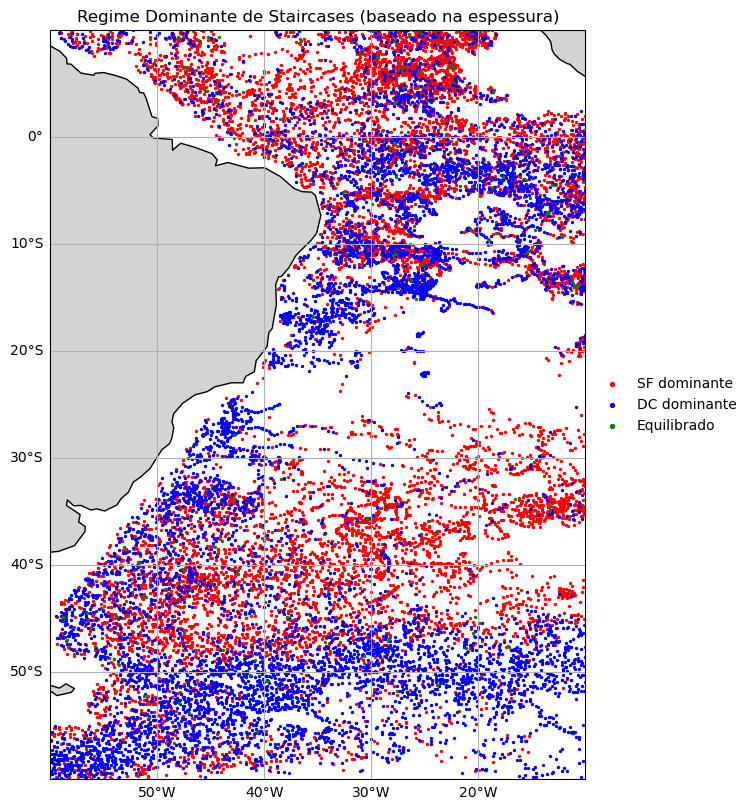

In [12]:
# Converter sets para listas (lon, lat)

if unique_sf_points:
    sf_lats, sf_lons = zip(*unique_sf_points)
    sf_lons, sf_lats = np.array(sf_lons), np.array(sf_lats)
else:
    sf_lons, sf_lats = [], []

if unique_dc_points:
    dc_lats, dc_lons = zip(*unique_dc_points)
    dc_lons, dc_lats = np.array(dc_lons), np.array(dc_lats)
else:
    dc_lons, dc_lats = [], []

if unique_mixed_points:
    mixed_lats, mixed_lons = zip(*unique_mixed_points)
    mixed_lons, mixed_lats = np.array(mixed_lons), np.array(mixed_lats)
else:
    mixed_lons, mixed_lats = [], []

# Plot

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-60, -10, -60, 10], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Plot regimes dominantes

ax.scatter(
    sf_lons, sf_lats,
    color="red",
    s=2,
    transform=ccrs.PlateCarree(),
    label="SF dominante"
)

ax.scatter(
    dc_lons, dc_lats,
    color="blue",
    s=2,
    transform=ccrs.PlateCarree(),
    label="DC dominante"
)

ax.scatter(
    mixed_lons, mixed_lats,
    color="green",
    s=2,
    transform=ccrs.PlateCarree(),
    label="Equilibrado"
)

# Legenda externa
ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    markerscale=2
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.title("Regime Dominante de Staircases (baseado na espessura)")
plt.show()
